https://www.youtube.com/watch?v=Qfk9WoOjGQ8

In [ ]:
!pip install telebot

In [9]:
'''roboflow - платформа с предобученными моделями
'''
!pip install roboflow supervision opencv-python

In [ ]:
!pip install inference

Регистрируем телеграмм-бота в ТГ.  
Находим пользователя @BotFather. Отправлем в сообщении: /newbot. Вводим имя (отображается оно) и уникальный его юзернейм. Выдается токен API.  
Регестрируемся в roboflow, создаем проект, получаем токен.  

In [10]:
import telebot
import requests
from inference import get_model
import supervision as sv
import cv2

In [11]:
API_TOKEN_TELEGRAM = '6912996410:AAFrofmB2wfi6hsVZ4xI4pE6Xkob1SxjkWc'
model_id_roboflow = 'car-damage-coco-dataset/4'
api_key_roboflow = 'bpBEGQKQ0Xzm4n4L3VPs'

In [20]:
bot = telebot.TeleBot(API_TOKEN_TELEGRAM)

# Настроим ответ на команды '/start' и '/help'
@bot.message_handler(commands=['help', 'start'])
def send_welcome(message):
    bot.reply_to(
        message,
        'Привет! \nПрисылай мне фотографию автомобиля после аварии и я отмечу на фотографии области полученных повреждений. \nТак же я умею отвечать на команды /start и /help. \
        '
    )


# Настроим ответ на остальные текстовые вводы
@bot.message_handler(func=lambda message: True)
def echo_message(message):
    bot.reply_to(
            message,
            'Простите, но я умею только в /start, /help и в картинки автомобилей :)!'
    )


@bot.message_handler(content_types=['photo'])
def handle_photo(message):
    photo = message.photo[-1]
    file_info = bot.get_file(photo.file_id)
    downloaded_file = bot.download_file(file_info.file_path)
    ## TODO а надо ли сохранять?
    save_path = 'photo.jpg'
    with open(save_path, 'wb') as new_file:
        new_file.write(downloaded_file)
    bot.reply_to(message, 'Спасибо! Фотография сохранена. Подождите немного!')
    # вызываем апи нашей модели
    # получаем фотографию с рамкой
    # отправляем пользователю в ответ на его сообщение
    image = cv2.imread('photo.jpg')

    # загружаем предобученую модель
    model = get_model(model_id=model_id_roboflow, api_key=api_key_roboflow)

    # получаем вывод модели
    results = model.infer(image)[0]

    # загружаем его в supervision Detections
    detections = sv.Detections.from_inference(results)
    # print(detections)
    bot.reply_to(
            message,
            detections
    )

    # создаем комментатор supervision
    bounding_box_annotator = sv.BoundingBoxAnnotator()
    label_annotator = sv.LabelAnnotator()

    # результаты анализа на картинку
    annotated_image = bounding_box_annotator.annotate(
        scene=image, detections=detections)
    annotated_image = label_annotator.annotate(
        scene=annotated_image, detections=detections)

    # выводим картинку
    # sv.plot_image(annotated_image)
    ## TODO не посылается :(
    bot.send_photo(
            photo,
            annotated_image
    )

bot.infinity_polling()


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
2024-07-21 08:12:46,692 (__init__.py:1221 MainThread) ERROR - TeleBot: "Threaded polling exception: A request to the Telegram API was unsuccessful. Error code: 400. Description: Bad Request: chat not found"
ERROR:TeleBot:Threaded polling exception: A request to the Telegram API was unsuccessful. Error code: 400. Description: Bad Request: chat not found
2024-07-21 08:12:46,695 (__init__.py:1223 MainThread) ERROR - TeleBot: "Exception traceback:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/telebot/__init__.py", line 1215, in __threaded_polling
    self.worker_pool.raise_exceptions()
  File "/usr/local/lib/python3.10/dist-packages/telebot/util.py", line 150, in raise_exceptions
    raise self.exception_info
  File "/usr/local/lib/python3.10/dist-packages/tele

Detections(xyxy=array([[  7., 261., 764., 811.]]), mask=array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]]), confidence=array([0.671]), class_id=array([1]), tracker_id=None, data={'class_name': array(['Car-Damage'], dtype='<U10')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


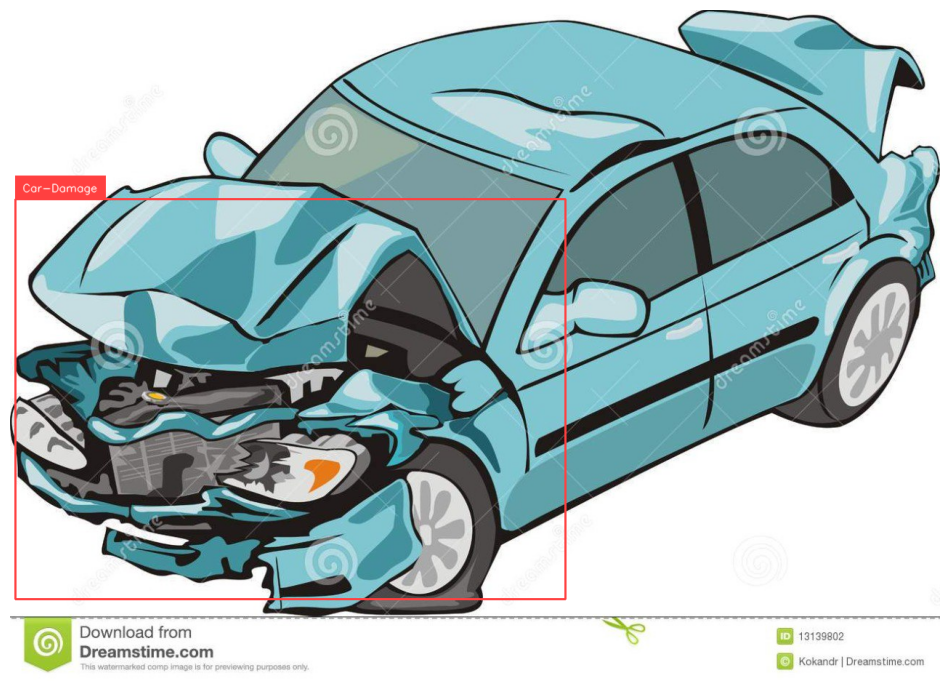

In [16]:
image = cv2.imread('photo.jpg')

# загружаем предобученую модель
model = get_model(model_id=model_id_roboflow, api_key=api_key_roboflow)

# получаем вывод модели
results = model.infer(image)[0]

# загружаем его в supervision Detections
detections = sv.Detections.from_inference(results)
print(detections)
# создаем комментатор supervision
bounding_box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()

# результаты анализа на картинку
annotated_image = bounding_box_annotator.annotate(
    scene=image, detections=detections)
annotated_image = label_annotator.annotate(
    scene=annotated_image, detections=detections)

# выводим картинку
sv.plot_image(annotated_image)